# 초기 환경 세팅

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -r "/content/drive/MyDrive/code/requirements.txt"

In [ ]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

Using matplotlib backend: <object object at 0x7d06af5536a0>


In [ ]:
# 경로 설정
data_path = '../data'
saved_path = './saved'
output_path = './submission'

In [ ]:
# 하이퍼파라미터
class cfg:
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25
    seed = 42
    neg_ratio = 100
    test_size = 0.1

In [ ]:
# 시드 고정
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

seed_everything(cfg.seed)

# 오리지날 학습 및 검증 데이터 생성
## 데이터 불러오기
- history_data : 시청 시작 데이터
- profile_data : 프로필 정보
- meta_data : 콘텐츠 일반 메타 정보
- buy_data : 콘텐츠 구매한 경우, 구매 액 정보
- watch_e_data : 콘텐츠 시청 종료 데이터
- search_data : 콘텐츠 검색 정보 데이터
- meta_data_plus : 콘텐츠 메타 정보 상세

In [ ]:
history_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/buy_data.csv'), encoding='utf-8')
watch_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/watch_e_data.csv'), encoding='utf-8')
search_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/search_data.csv'), encoding='utf-8')
metap_df = pd.read_csv(os.path.join(data_path, '/content/drive/MyDrive/data/meta_data_plus.csv'), encoding='utf-8')

## 데이터 전처리


In [ ]:
# 시청 시작 데이터 main활용
h_df = history_df[['profile_id','log_time','album_id']]

# 유저 메타 정보 취합
df = pd.merge(h_df, profile_df[['profile_id','sex','age']], 'left', on = 'profile_id')

# 아이템 메타 정보 취합
df = pd.merge(df, meta_df, 'left', on = 'album_id')

# 유저의 아이템에 대한 조회 수 정보 취합
view_cnts = df.groupby('profile_id')['album_id'].count()
df['views'] = df['profile_id'].map(lambda x: view_cnts[x])

# 검색 정보 취합
search = search_df[['profile_id','album_id']].drop_duplicates()
search['search'] = 1
df = pd.merge(df, search[['profile_id','album_id','search']], 'left', on=['profile_id','album_id'])

# 구매 금액 정보 취합
df = pd.merge(df,buy_df[['profile_id','album_id','payment']].drop_duplicates(), 'left', on = ['profile_id','album_id'])
df['payment'] = df['payment'].fillna(0)
df['payment'] = df['payment'].map(lambda x: 0 if x == 0 else 1)

## 랜덤 샘플링 위한 data 변환

In [ ]:
# 단순 소비 정보 룩업테이블 생성
data = df[['profile_id','log_time','album_id','views']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1
data.shape

(899252, 5)

In [ ]:
# 네거티브 샘플링을 위한 매트릭스 구조 형성용 유저, 아이템 최대값 생성
cfg.n_users = data.profile_id.max()+1
cfg.n_items = data.album_id.max()+1

In [ ]:
# 조회수가 1인 고객 제거 -> 모델 효율화
data_new = data.drop(data[data['views']==1].index).reset_index()

In [ ]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data_new, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (809050, 6)
검증 데이터 크기: (89895, 6)


In [ ]:
# Matrix 형태로 변환
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))
for (idx, p, _, i, r, view) in tqdm(train):
    matrix[p, i] = r

train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

  0%|          | 0/809050 [00:00<?, ?it/s]

train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 모델 검증용 실제이터 룩업 딕셔너리 생성

In [ ]:
# 유저 특징 정보 추출
df = df.set_index('profile_id')
user_features = df[['age']].to_dict()
# # 성별, view, continuous 추가
df['sex'] = df['sex'].map(lambda x: 1 if x == 'M' else 0)

user_id 3의 age 정보 : 5
user_id 3의 sex 정보 : 0
user_id 3의 views 정보 : 23


In [ ]:
# 아이템 특징 정보 추출
# 범주형 데이터를 수치형 데이터로 변경
le = LabelEncoder()
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
item_features = meta_df[['genre_mid']].to_dict()
item_features_run = meta_df[['run_time']].to_dict()

In [ ]:
# 검색 상호작용 딕셔너리 생성
search = search[search['album_id']<cfg.n_items]
search_dict = {}
for i in tqdm(search['profile_id'].unique()):
  search_dict[i] = list(search[search['profile_id']== i]['album_id'].values)

  0%|          | 0/644 [00:00<?, ?it/s]

In [ ]:
# 구매 상호작용 딕셔너리 생성
buy = buy_df[['profile_id','album_id','payment']]
buy_dict = {}
for i in tqdm(buy['profile_id'].unique()):
  buy_dict[i] = list(buy[buy['profile_id']== i]['album_id'].values)

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# 추출한 특징 정보의 속성을 저장
cfg.n_genres = meta_df['genre_mid'].nunique()
cfg.n_sex = df['sex'].nunique()
cfg.n_search = 2
cfg.n_continuous_feats = 4

## NeuMF 구현


### 모델 구현
- User's feature (age, sex)
- Item's features (genre_mid, runtime)
- User & Items' features (views, search, payment)를 같이 학습할 수 있도록 결합

![](http://drive.google.com/uc?export=view&id=1tpajTLipLoFdvLICO-alAxeoKAE8-k61)

In [ ]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg)
        output = model.forward(user_ids, item_ids, [feat0, feat1])
    """
    def __init__(self, cfg):
        """
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        # self.n_keywords = cfg.n_keywords
        self.n_genres = cfg.n_genres
        self.n_sex = cfg.n_sex
        self.n_search = cfg.n_search
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고
        """
        # mf용 유저임베딩 - 유저 임베딩 수 == 유저 cfg 수, 임베딩 차원 수 == 256
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)

        # mlp 용 유저 임베딩, 차원 수도 동일한 방법
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)

        # mlp 용 특성 장르 임베딩 설정
        self.genre_embeddig = nn.Embedding(num_embeddings=self.n_genres, embedding_dim=self.n_genres//2)
        # mlp 용 특성 성별 임베딩 설정
        self.sex_embeddig = nn.Embedding(num_embeddings=self.n_sex, embedding_dim=self.n_sex//2)
        # mlp 용 특성 search 임베딩 설정
        self.search_embedding = nn.Embedding(num_embeddings=self.n_search, embedding_dim=self.n_search//2)


        # mlp 레이어 - 시퀜셜 모델로 생성
        self.mlp_layers = nn.Sequential(
            # 첫번째 인자값은 input size, 두번째 인자값은 output size이다
            nn.Linear(2*self.emb_dim + self.n_genres//2 + self.n_sex//2 + self.n_search//2 + self.n_continuous_feats , self.layer_dim), # +self.n_keywords
            nn.ReLU(),
            nn.Dropout(p=self.dropout),
            nn.Linear(self.layer_dim, self.layer_dim//2),
            nn.ReLU(),
            nn.Dropout(p=self.dropout)
        )

        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)

    def forward(self, user_indices, item_indices, feats):
        """
        Args:
            user_indices : 유저의 인덱스 정보
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보
        Returns:
            output : 유저-아이템 쌍에 대한 추천 결과
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        # 임베딩 진행
        user_embedding_mf = self.user_embedding_mf(user_indices)    # 유저의 MF 임베딩
        item_embedding_mf = self.item_embedding_mf(item_indices)    # 아이템의 MF 임베딩
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf) # 유저 아이템 MF 결과값

        user_embedding_mlp = self.user_embedding_mlp(user_indices)  # 유저 id MLP 임베딩
        item_embedding_mlp = self.item_embedding_mlp(item_indices)  # 아이템 id MLP 임베딩
        genre_embedding_mlp = self.genre_embeddig(feats[3])         # 아이템 장르 MLP 임베딩

        sex_embedding_mlp = self.sex_embeddig(feats[2])             # 유저 성별 MLP 임베딩 추가
        search_embedding_mlp = self.search_embedding(feats[5])      # 유저 검색여부 MLP 임베딩 추가

        # 유저 아이템 MLP 임베딩 정보의 합산
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_embedding_mlp, sex_embedding_mlp, \
        search_embedding_mlp, feats[0].unsqueeze(1), feats[1].unsqueeze(1),feats[4].unsqueeze(1), feats[6].unsqueeze(1)),  -1)

        if input_feature.shape[0] != 0:                             # 유저 네거티브 샘플링으로 인한 오류 방지
          mlp_output = self.mlp_layers(input_feature)
          output = torch.cat([mlp_output, mf_output], dim=-1)       # MLP 및 MF 결과값 합산
          output = self.affine_output(output).squeeze(-1)           # 합산 임베딩을 선형결합하여 최종 스코어 산출
          return output
        else:
          pass


### 학습 및 추론 코드 구현

- 학습 : Negative sampling을 활용하여 Binary Classification 진행
    - history 에 있는 album_id는 positive label로 그렇지 않은 album_id는 nagative label로 활용  
    - 단, 이때 모든 album_id를 negative label로 활용하는 것이 아닌 일부만 사용 (neg_ratio 값에 따라서 개수 조정)
- 추론 : 일부 데이터에 대해 recall, ndcg, coverage 성능 확인

#### 학습 및 추론에 필요한 데이터 셋 생성 코드 구현

In [ ]:
def make_UIdataset(train, neg_ratio):
    """ 유저별 학습에 필요한 딕셔너리 데이터 생성
    Args:
        train : 유저-아이템의 상호작용을 담은 행렬
            ex)
                array([[0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        ...,
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.],
                        [0., 0., 0., ..., 0., 0., 0.]])
        neg_ratio : negative sampling 활용할 비율
            ex) 3 (positive label 1개당 negative label 3개)
    Returns:
        UIdataset : 유저별 학습에 필요한 정보를 담은 딕셔너리
            ex) {'사용자 ID': [[positive 샘플, negative 샘플], ... , [1, 1, 1, ..., 0, 0]]}
                >>> UIdataset[3]
                    [array([   16,    17,    18, ...,  9586, 18991,  9442]),
                    array([5, 5, 5, ..., 5, 5, 5]),
                    array([4, 4, 4, ..., 5, 1, 1]),
                    array([1., 1., 1., ..., 0., 0., 0.])]
    """
    UIdataset = {}
    for user_id, items_by_user in enumerate(train):

      UIdataset[user_id] = []
      # positive 샘플 계산
      # pos item은 0.5 이상인 것들의 index를 찾아 출력
      pos_item_ids = np.where(items_by_user > 0.5)[0]
      # pos 샘플 개수
      num_pos_samples = len(pos_item_ids)

      # negative 샘플 계산 (random negative sampling)
      # neg 샘플 개수
      num_neg_samples = neg_ratio * num_pos_samples
      neg_items = np.where(items_by_user < 0.5)[0]
      # neg 샘플 중 랜덤 초이스
      neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
      # pos, neg 샘플 짝지어서 UIdataset에 넣기
      UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))

      # feature 추출
      features_age = []
      features_views = []
      features_sex = []
      # pos, neg 쌍을 하나씩 뽑고,
      for item_id in np.concatenate([pos_item_ids, neg_item_ids]):
          # user_features의 user에 따른 나이를 features에 넣기
          features_age.append(user_features['age'][user_id])  # float
          features_views.append(user_features_views['views'][user_id])  # float
          features_sex.append(user_features_sex['sex'][user_id])  # long
      #나이 정보 순서를 append해서 모든 쌍에 추가해주기
      UIdataset[user_id].append(np.array(features_age))
      UIdataset[user_id].append(np.array(features_views))
      UIdataset[user_id].append(np.array(features_sex))

      features_genre = []
      features_run = []
      features_search = []
      features_payment = []
      # features_keywords = []
      # pos와 neg 일렬 리스트로 변환
      for item_id in np.concatenate([pos_item_ids, neg_item_ids]):
          # item_features의 item에 따른 장르를 features에 넣기

          features_genre.append(item_features['genre_mid'][item_id])  # long
          features_run.append(item_features_run['run_time'][item_id]) # float
          # features_keywords.append(keyword_embedding[item_id])
          if user_id in search_dict.keys():
            if item_id in search_dict[user_id]:
              features_search.append(1)
            else:
              features_search.append(0)
          else:
            features_search.append(0)
          if user_id in buy_dict.keys():
            if item_id in buy_dict[user_id]:
              features_payment.append(int(buy[(buy['profile_id']==user_id)&(buy['album_id']==item_id)]['payment'].values[0]))
            else:
              features_payment.append(0)
          else:
            features_payment.append(0)


      #장르 정보를 append해서 모든 쌍에 추가해주기 -> 상호작용에 feature가 추가된것임
      UIdataset[user_id].append(np.array(features_genre))
      UIdataset[user_id].append(np.array(features_run))
      UIdataset[user_id].append(np.array(features_search))
      UIdataset[user_id].append(np.array(features_payment))
      # if len(features_keywords) == 0:
      #   UIdataset[user_id].append(np.array(features_keywords))
      # else:
      #   UIdataset[user_id].append(features_keywords)
      # label 저장
      pos_labels = np.ones(len(pos_item_ids))
      neg_labels = np.zeros(len(neg_item_ids))
      UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

    return UIdataset

In [ ]:
# 데이터셋 생성
UIdataset = make_UIdataset(train, neg_ratio=cfg.neg_ratio)

In [ ]:
UIdataset[3]

[array([  16,   17,   18, ..., 8247,  982, 6646]),
 array([5, 5, 5, ..., 5, 5, 5]),
 array([23, 23, 23, ..., 23, 23, 23]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([ 1,  1,  1, ...,  5, 22,  5]),
 array([ 660,  660,  660, ..., 1077, 2869,  268]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1., 1., 1., ..., 0., 0., 0.])]

In [ ]:
def make_batchdata(user_indices, batch_idx, batch_size):
    """ 배치 데이터로 변환
    Args:
        user_indices : 전체 유저의 인덱스 정보
            ex) array([ 3100,  1800, 30098, ...,  2177, 11749, 20962])
        batch_idx : 배치 인덱스 (몇번째 배치인지)
            ex) 0
        batch_size : 배치 크기
            ex) 256
    Returns
        batch_user_ids : 배치내의 유저 인덱스 정보
            ex) [22194, 22194, 22194, 22194, 22194, ...]
        batch_item_ids : 배치내의 아이템 인덱스 정보
            ex) [36, 407, 612, 801, 1404, ...]
        batch_feat0 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature0 정보
            ex) [6, 6, 6, 6, 6, ...]
        batch_feat1 : 배치내의 유저-아이템 인덱스 정보에 해당하는 feature1 정보
            ex) [4,  4,  4, 23,  4, ...]
        batch_labels : 배치내의 유저-아이템 인덱스 정보에 해당하는 label 정보
            ex) [1.0, 1.0, 1.0, 1.0, 1.0, ...]
    """
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []  # age
    batch_feat1 = []  # views
    batch_feat2 = []  # sex
    batch_feat3 = []  # genre
    batch_feat4 = []  # runtime
    batch_feat5 = []  # search
    batch_feat6 = []  # payment
    batch_labels = [] # label
    for user_id in batch_user_indices:
        item_ids = UIdataset[user_id][0]
        feat0 = UIdataset[user_id][1]
        feat1 = UIdataset[user_id][2]
        feat2 = UIdataset[user_id][3]
        feat3 = UIdataset[user_id][4]
        feat4 = UIdataset[user_id][5]
        feat5 = UIdataset[user_id][6]
        feat6 = UIdataset[user_id][7]
        # feat7 = UIdataset[user_id][8]
        labels = UIdataset[user_id][8]
        user_ids = np.full(len(item_ids), user_id)  # 모든 값을 user_id로 통일
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())
        batch_feat5.extend(feat5.tolist())
        batch_feat6.extend(feat6.tolist())
        # batch_feat7.extend(feat7)
        batch_labels.extend(labels.tolist())
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_feat2, \
    batch_feat3, batch_feat4,batch_feat5, batch_feat6, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산
    """
    return (curr_avg * idx + val) / (idx + 1)

#### 학습 및 검증 코드 생성

In [ ]:
def train_epoch(cfg, model, optimizer, criterion):
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)


    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1,feat2, feat3, feat4,feat5, feat6, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size) #feat7,
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        feat0 = torch.FloatTensor(feat0).to(cfg.device)
        feat1 = torch.FloatTensor(feat1).to(cfg.device)
        feat2 = torch.LongTensor(feat2).to(cfg.device)
        feat3 = torch.LongTensor(feat3).to(cfg.device)
        feat4 = torch.FloatTensor(feat4).to(cfg.device)
        feat5 = torch.LongTensor(feat5).to(cfg.device)
        feat6 = torch.FloatTensor(feat6).to(cfg.device)
        # feat7 = torch.FloatTensor(feat7).to(cfg.device)
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5, feat6])# , feat7
        if output is not None:
          output = output.view(-1, 1)

          loss = criterion(output, labels)

          # 역전파
          loss.backward()

          # 최적화
          optimizer.step()
          if torch.isnan(loss):
              print('Loss NAN. Train finish.')
              break
          curr_loss_avg = update_avg(curr_loss_avg, loss, step)

          msg = f"epoch: {cfg.epoch}, "
          msg += f"loss: {curr_loss_avg.item():.5f}, "
          msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
          bar.set_description(msg)
        else:
          pass
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [ ]:
def recallk(actual, predicted, k = 25):
    """ label과 prediction 사이의 recall 평가 함수
    Args:
        actual : 실제로 본 상품 리스트
        pred : 예측한 상품 리스트
        k : 상위 몇개의 데이터를 볼지 (ex : k=5 상위 5개의 상품만 봄)
    Returns:
        recall_k : recall@k
    """
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))])
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    """ label과 prediction 사이의 recall, coverage, competition metric 평가 함수
    Args:
        gt : 데이터 프레임 형태의 정답 데이터
        pred : 데이터 프레임 형태의 예측 데이터
    Returns:
        rets : recall, ndcg, coverage, competition metric 결과
            ex) {'recall': 0.123024, 'ndcg': 056809, 'coverage': 0.017455, 'score': 0.106470}
    """
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall,
            "ndcg" :ndcg,
            "coverage" :coverage,
            "score" :score}
    return rets

In [ ]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()

    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합
    # full_item_ids_feat1 = [item_features['genre_mid'][c] for c in full_item_ids]
    full_item_ids_feat3 = [item_features['genre_mid'][c] for c in full_item_ids]
    full_item_ids_feat4 = [item_features_run['run_time'][c] for c in full_item_ids]
    # cnt = CountVectorizer(min_df=1, ngram_range = (1,1))
    # df_cnt = cnt.fit_transform(meta_new[meta_new['album_id']<cfg.n_items]['features'].values)
    # a_matrix = pd.DataFrame(df_cnt.todense(), columns = cnt.get_feature_names())
    for user_id in query_user_ids:
        # 텐서에 연산 기록을 중지하고, 학습된 모델로 inference하는 과정
        with torch.no_grad():
          user_ids = np.full(cfg.n_items, user_id)

          user_ids = torch.LongTensor(user_ids).to(cfg.device)
          item_ids = torch.LongTensor(full_item_ids).to(cfg.device)

          feat0 = np.full(cfg.n_items, user_features['age'][user_id])
          feat0 = torch.FloatTensor(feat0).to(cfg.device)
          feat1 = np.full(cfg.n_items, user_features_views['views'][user_id])
          feat1 = torch.FloatTensor(feat1).to(cfg.device)
          feat2 = np.full(cfg.n_items, user_features_sex['sex'][user_id])
          feat2 = torch.LongTensor(feat2).to(cfg.device)
          feat3 = torch.LongTensor(full_item_ids_feat3).to(cfg.device)
          feat4 = torch.FloatTensor(full_item_ids_feat4).to(cfg.device)
          # detach로 validation set에 대한 그래프 history 차단 후 inference
          feat5 = np.zeros(cfg.n_items)
          if user_id in search_dict.keys():
            np.put(feat5, search_dict[user_id], 1)
          feat5 = torch.LongTensor(feat5).to(cfg.device)
          feat6 = np.zeros(cfg.n_items)
          if user_id in buy_dict.keys():
            np.put(feat6, buy_dict[user_id], buy[(buy['profile_id']==user_id)&(buy['album_id']==buy_dict[user_id][0])]['payment'].values[0])
          feat6 = torch.FloatTensor(feat6).to(cfg.device)
          # feat7_lst = keyword_embedding
          # feat7 = torch.FloatTensor(feat7_lst).to(cfg.device)
          eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5, feat6]).detach().cpu().numpy()#, feat7
          pred_u_score = eval_output.reshape(-1)


        pred_u_idx = np.argsort(pred_u_score)[::-1]         # 최종 스코어 높은 순서대로 인덱스 뽑기

        pred_u = full_item_ids[pred_u_idx]                  # 전체 아이템 중에서 스코어가 높은 인덱스들 뽑아 리스트 가져오기

        pred_list.append(list(pred_u[:cfg.top_k]))          # top_k개 만큼을 pred_list에 넣기

    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list

    # 모델 성능 확인
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

## 모델 학습

### 하이퍼파라미터 설정 & 최적화 기법 설정

In [ ]:
# 하이퍼 파라미터 설정
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.05
cfg.epochs = 10
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [ ]:
# model 생성 및 optimizer, loss 함수 설정
model_re = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model_re.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

### 학습 진행

In [ ]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model_re, optimizer, criterion)

    # cfg.check_epoch 번의 epoch 마다 성능 확인
    if epoch % cfg.check_epoch == 0:
        valid_results, _ = valid_epoch(cfg, model_re, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")

            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))

        # 가장 성능이 좋은 가중치 파일을 저장
        if best_scores <= valid_results['score']:
            best_scores = valid_results['score']
            torch.save(model_re.state_dict(), os.path.join('/content/drive/MyDrive/code/saved', 'model_re(best_scores).pth'))

  0%|          | 0/130 [00:00<?, ?it/s]

Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  20350.978520  0.135873  0.087817  0.003967  0.123859


  0%|          | 0/130 [00:00<?, ?it/s]

01  11412.557620  0.199649  0.141315  0.005516  0.185066


  0%|          | 0/130 [00:00<?, ?it/s]

02  9143.462890  0.330972  0.214504  0.053331  0.301855


  0%|          | 0/130 [00:00<?, ?it/s]

03  7512.552730  0.407553  0.263289  0.101638  0.371487


  0%|          | 0/130 [00:00<?, ?it/s]

04  5331.582030  0.457592  0.287542  0.180156  0.415079


  0%|          | 0/130 [00:00<?, ?it/s]

05  3570.309810  0.471094  0.293325  0.255528  0.426652


  0%|          | 0/130 [00:00<?, ?it/s]

06  2426.772220  0.479201  0.298451  0.289799  0.434013


  0%|          | 0/130 [00:00<?, ?it/s]

07  1653.789920  0.479100  0.299006  0.291817  0.434076


  0%|          | 0/130 [00:00<?, ?it/s]

08  1174.094970  0.482663  0.298377  0.325947  0.436592


  0%|          | 0/130 [00:00<?, ?it/s]

09  878.679690  0.482495  0.299258  0.318178  0.436686


  0%|          | 0/130 [00:00<?, ?it/s]

10  644.281620  0.481371  0.298565  0.333365  0.435670


### 학습 과정 시각화

학습된 데이터 저장

In [ ]:
# import pickle
# with open ('/content/drive/MyDrive/code/saved/valid_scores.pkl', 'wb') as f:
#   pickle.dump(valid_scores, f)

# with open ('/content/drive/MyDrive/code/saved/train_scores.pkl', 'wb') as f:
#   pickle.dump(train_scores, f)

# with open ('/content/drive/MyDrive/code/saved/total_logs.pkl', 'wb') as f:
#   pickle.dump(total_logs, f)

In [ ]:
#불러오기
import pickle
with open('/content/drive/MyDrive/code/saved/total_logs.pkl', 'rb') as f:
    total_logs = pickle.load(f)

with open('/content/drive/MyDrive/code/saved/train_scores.pkl', 'rb') as f:
    train_scores = pickle.load(f)
with open('/content/drive/MyDrive/code/saved/valid_scores.pkl', 'rb') as f:
    valid_scores = pickle.load(f)

In [ ]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

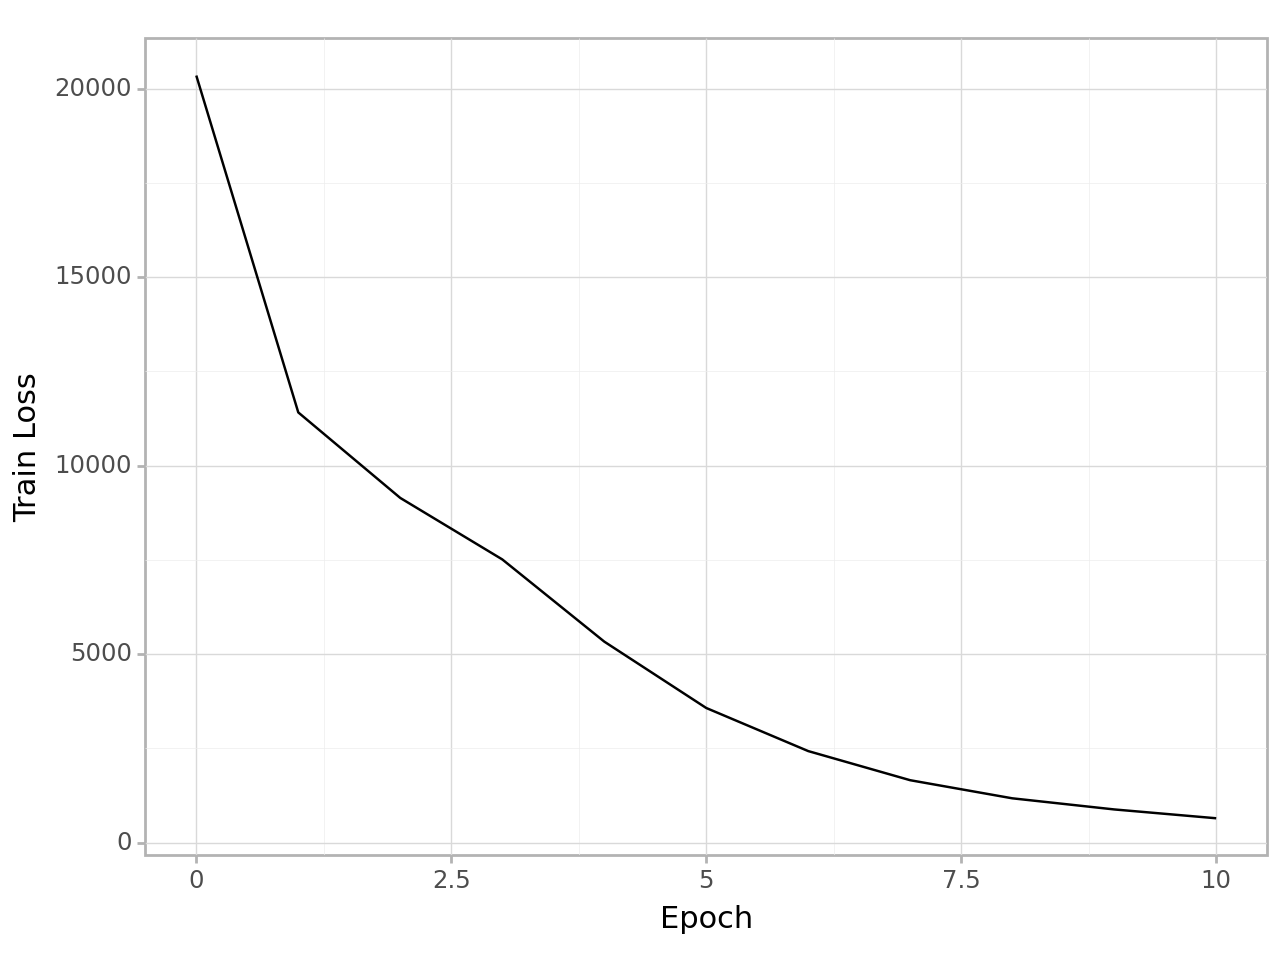

<Figure Size: (640 x 480)>

In [ ]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))+ geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [ ]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

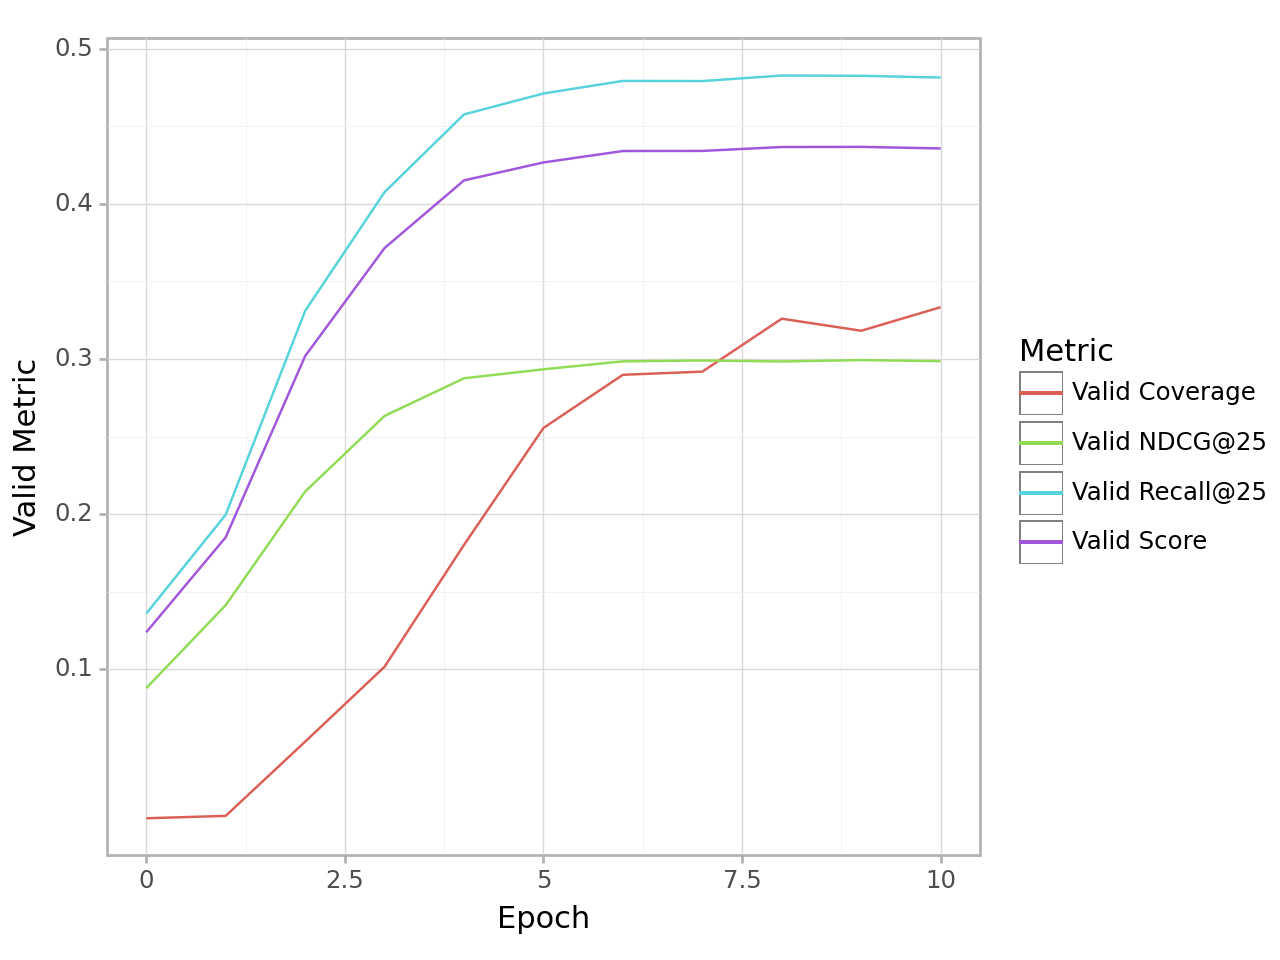

<Figure Size: (640 x 480)>

In [ ]:
%matplotlib inline

(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)

## 제출

In [ ]:
model4.load_state_dict(torch.load(os.path.join('/content/drive/MyDrive/code/saved', 'model4(best_scores).pth')))

In [ ]:
meta[meta['album_id']==34453]

In [ ]:
submission_path = os.path.join('/content/drive/MyDrive/data', 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model4, submission, mode='test')